## Implementasi Metode Lama : Active Contour
### Mendapatkan Data dan Import Library

In [4]:
import cv2               as cv
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import os
import time

from skimage.filters import gaussian
from skimage.segmentation import active_contour

DATASET_PATH = 'Wound_dataset/'

def pick(data, number):
    parent = data.capitalize()
    child = data.lower()
    if parent == 'Ingrown_nails':
        child = 'ingrown_nail'
    if parent == 'Laceration':
        child = 'laseration'
    path = DATASET_PATH + parent + '/' + child + ' (' + str(number) + ').jpg'
    if not os.path.exists(path):
        print('File tidak ditemukan')
    return path

citra = cv.imread(pick('laceration', 15))

## Pre-processing

### Grayscaling

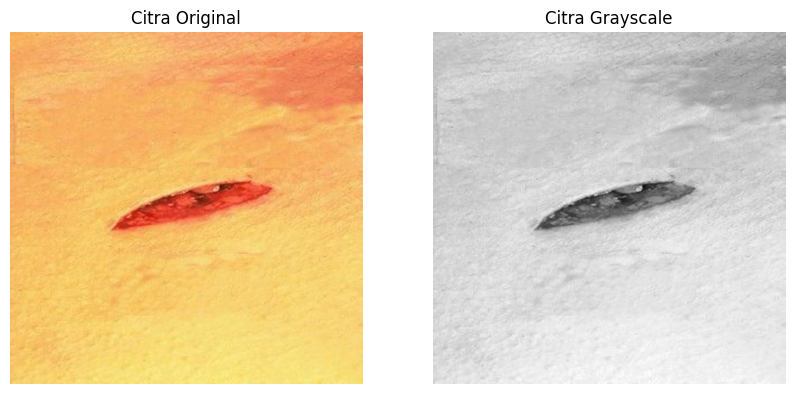

In [5]:
citra_rgb = citra[..., ::-1]

R = citra_rgb[..., 0]
G = citra_rgb[..., 1]
B = citra_rgb[..., 2]

citra_grayscale = 0.2989 * R + 0.5870 * G + 0.1140 * B

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(citra_rgb)
axes[0].set_title("Citra Original")
axes[0].axis('off')
axes[1].imshow(citra_grayscale, cmap='gray')
axes[1].set_title("Citra Grayscale")
axes[1].axis('off')

plt.show()

### Pencerahan

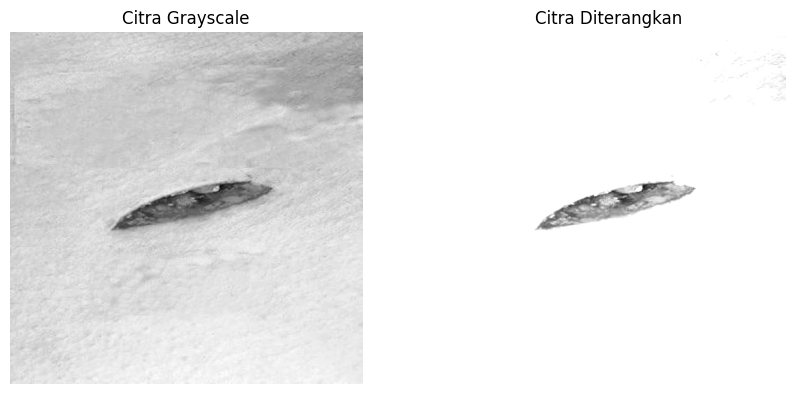

In [7]:
brightness = 100
citra_brightened = citra_grayscale + brightness

citra_brightened = np.clip(citra_brightened, 0, 255).astype(np.uint8)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_grayscale, cmap='gray')
axes[0].set_title("Citra Grayscale")
axes[0].axis('off')
axes[1].imshow(citra_brightened, cmap='gray')
axes[1].set_title("Citra Diterangkan")
axes[1].axis('off')
plt.show()

### Denoising Citra

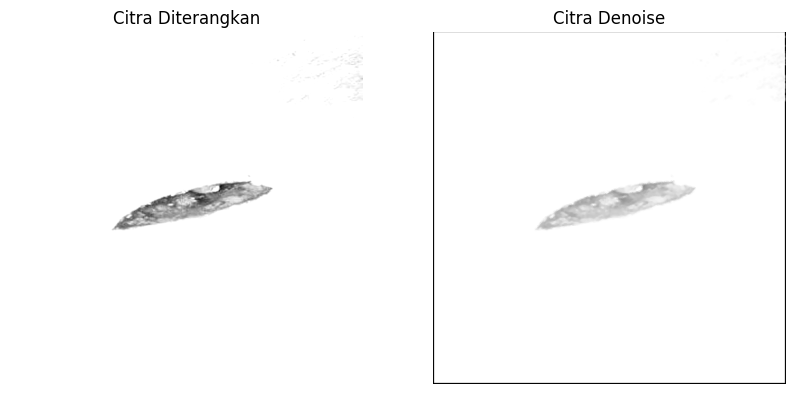

In [8]:
def manual_median_blur(image):
    m, n = image.shape
    median_blurred = np.zeros((m, n), dtype=np.uint8)
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            window = image[i - 1:i + 2, j - 1:j + 2]
            median_blurred[i, j] = np.median(window)
    return median_blurred

# Fast Non-Local Means Denoising (Fungsi Buatan)
def manual_fast_nl_means_denoising(image, N1, N2, h):
    m, n = image.shape
    denoised_image = np.zeros((m, n), dtype=np.float32)
    for i in range(N1, m - N1):
        for j in range(N2, n - N2):
            window_search = image[i - N1:i + N1 + 1, j - N2:j + N2 + 1]
            weights = np.exp(-((window_search - image[i, j]) ** 2) / (h ** 2))
            normalized_weights = weights / np.sum(weights)
            denoised_image[i, j] = np.sum(window_search * normalized_weights)
    return denoised_image.astype(np.uint8)

# Menjalankan Median Blur Secara Manual
citra_denoise_manual_median = manual_median_blur(citra_brightened)

# Menjalankan Fast Non-Local Means Denoising Secara Manual
citra_denoise_manual_nl_means = manual_fast_nl_means_denoising(citra_denoise_manual_median, 1, 1, 7)


fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_brightened, cmap='gray')
axes[0].set_title("Citra Diterangkan")
axes[0].axis('off')
axes[1].imshow(citra_denoise_manual_nl_means, cmap='gray')
axes[1].set_title("Citra Denoise")
axes[1].axis('off')
plt.show()

### Penyesuaian Kontras

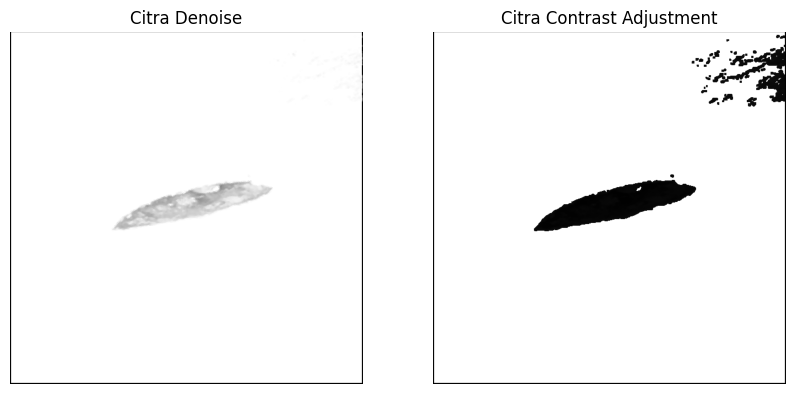

In [9]:
# Histogram Equalization (Fungsi Buatan)
def manual_histogram_equalization(image):
    # Hitung histogram
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))

    # Hitung distribusi kumulatif
    cdf = histogram.cumsum()

    # Normalisasi distribusi kumulatif
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())

    # Lakukan mapping intensitas
    image_equalized = np.interp(image.flatten(), range(256), cdf_normalized).reshape(image.shape)

    return image_equalized.astype(np.uint8)

# Menjalankan Histogram Equalization Secara Manual
citra_contrast_adjusted_manual = manual_histogram_equalization(citra_denoise_manual_nl_means)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_denoise_manual_nl_means, cmap='gray')
axes[0].set_title("Citra Denoise")
axes[0].axis('off')
axes[1].imshow(citra_contrast_adjusted_manual, cmap='gray')
axes[1].set_title("Citra Contrast Adjustment")
axes[1].axis('off')
plt.show()

### Segmentasi dengan Active Contour

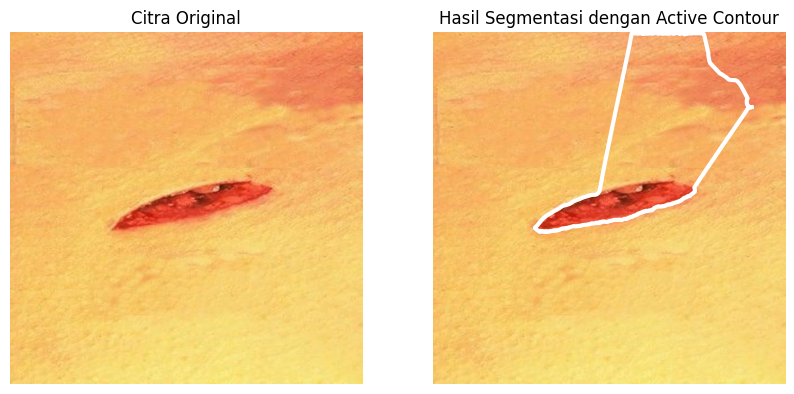

NameError: name 'citra_denoise' is not defined

In [11]:
s = np.linspace(0, 2*np.pi, 500)
r = 300 + 300*np.sin(s)
c = 320 + 300*np.cos(s)
init = np.array([r, c]).T

# Segmentasi dengan Active Contour
snake = active_contour(gaussian(citra_contrast_adjusted_manual, 3, preserve_range=False),
                       init, alpha=0.01, beta=0, gamma=0.001)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].set_title("Citra Original")
axes[0].imshow(citra[...,::-1], cmap='gray')
axes[0].axis('off')
axes[1].imshow(citra[...,::-1], cmap='gray')
axes[1].plot(snake[:, 1], snake[:, 0], '-w', lw=3)
axes[1].set_title("Hasil Segmentasi dengan Active Contour")
axes[1].axis('off')
plt.show()

selisih = np.array(citra_denoise) - np.array(citra[:, :, 0])
mse = np.mean(np.square(selisih))
psnr = 10 * np.log10(255 / np.sqrt(mse))
print("MSE :", mse)
print("PSNR:", psnr)

## Penerapan Active Contour pada Citra yang terdapat pada Datasets

### Fungsi Active Contour

In [4]:
# Fungsi untuk konversi citra ke grayscale
def grayscale(citra):
    citra_rgb = citra[..., ::-1]
    R, G, B = citra_rgb[..., 0], citra_rgb[..., 1], citra_rgb[..., 2]
    citra_grayscale = 0.2989 * R + 0.5870 * G + 0.1140 * B
    return citra_rgb, citra_grayscale

# Fungsi untuk menyesuaikan kecerahan citra grayscale
def brightness(bright, citra_grayscale):
    citra_brightened = np.clip(citra_grayscale + bright, 0, 255).astype(np.uint8)
    return citra_brightened

# Fungsi untuk median blur manual
def manual_median_blur(image):
    m, n = image.shape
    median_blurred = np.zeros((m, n), dtype=np.uint8)
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            window = image[i - 1:i + 2, j - 1:j + 2]
            median_blurred[i, j] = np.median(window)
    return median_blurred

# Fungsi untuk denoising dengan NL means secara manual
def manual_fast_nl_means_denoising(image, N1, N2, h):
    m, n = image.shape
    denoised_image = np.zeros((m, n), dtype=np.float32)
    for i in range(N1, m - N1):
        for j in range(N2, n - N2):
            window_search = image[i - N1:i + N1 + 1, j - N2:j + N2 + 1]
            weights = np.exp(-((window_search - image[i, j]) ** 2) / (h ** 2))
            normalized_weights = weights / np.sum(weights)
            denoised_image[i, j] = np.sum(window_search * normalized_weights)
    return denoised_image.astype(np.uint8)

# Fungsi untuk equalisasi histogram manual
def manual_histogram_equalization(image):
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))
    cdf = histogram.cumsum()
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    image_equalized = np.interp(image.flatten(), np.arange(256), cdf_normalized).reshape(image.shape)
    return image_equalized.astype(np.uint8)

# Fungsi Gaussian Filter (Manual)
def manual_gaussian_filter(image, sigma):
    size = int(6 * sigma) + 1
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2) / (2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    filtered_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            patch = image[max(0, i-size//2):min(image.shape[0], i+size//2+1), max(0, j-size//2):min(image.shape[1], j+size//2+1)]
            filtered_image[i, j] = np.sum(patch * kernel[:patch.shape[0], :patch.shape[1]])
    return filtered_image.astype(np.uint8)

# Fungsi untuk inisialisasi kurva awal
def initialize_curve(x, a, y, b):
    s = np.linspace(0, 2*np.pi, 500)
    r, c = x + a * np.sin(s), y + b * np.cos(s)
    init = np.array([r, c]).T
    return init

# Fungsi untuk menghitung gradien citra
def compute_image_gradients(image):
    grad_x = np.gradient(image, axis=1)
    grad_y = np.gradient(image, axis=0)
    return grad_x, grad_y

# Fungsi untuk menghitung energi eksternal
def external_energy(image, snake):
    grad_x, grad_y = compute_image_gradients(image)
    fx = np.array([grad_x[int(y), int(x)] for y, x in snake])
    fy = np.array([grad_y[int(y), int(x)] for y, x in snake])
    return fx, fy

# Fungsi untuk menghitung energi internal
def internal_energy(snake, alpha, beta):
    diff1 = np.roll(snake, -1, axis=0) - snake
    diff2 = np.roll(snake, -2, axis=0) - 2 * snake + np.roll(snake, 1, axis=0)
    elastic_energy = alpha * np.sum(diff1**2, axis=1)
    bending_energy = beta * np.sum(diff2**2, axis=1)
    return elastic_energy + bending_energy

# Fungsi untuk melakukan segmentasi active contour manual
def manual_active_contour(image, init, alpha, beta, gamma, num_iterations=2500):
    for _ in range(num_iterations):
        fx, fy = external_energy(image, init)
        internal = internal_energy(init, alpha, beta)
        init[:, 0] += gamma * (fy - internal)
        init[:, 1] += gamma * (fx - internal)
        init[:, 0] = np.clip(init[:, 0], 0, image.shape[0] - 1)
        init[:, 1] = np.clip(init[:, 1], 0, image.shape[1] - 1)
    return init

# Fungsi untuk menampilkan hasil
def display_results(citra_rgb, citra_grayscale, citra_brightened, citra_denoise_manual_median, citra_denoise_manual_nl_means, citra_contrast_adjusted_manual, snake):
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    
    axes[0, 0].imshow(citra_rgb)
    axes[0, 0].set_title("Citra Original")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(citra_grayscale, cmap='gray')
    axes[0, 1].set_title("Citra Grayscale")
    axes[0, 1].axis('off')

    axes[1, 0].imshow(citra_brightened, cmap='gray')
    axes[1, 0].set_title("Citra Diterangkan")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(citra_denoise_manual_median, cmap='gray')
    axes[1, 1].set_title("Citra Median Blur")
    axes[1, 1].axis('off')

    axes[2, 0].imshow(citra_denoise_manual_nl_means, cmap='gray')
    axes[2, 0].set_title("Citra Denoise NL Means")
    axes[2, 0].axis('off')

    axes[2, 1].imshow(citra_contrast_adjusted_manual, cmap='gray')
    axes[2, 1].set_title("Citra Contrast Adjustment")
    axes[2, 1].axis('off')

    axes[3, 0].imshow(citra_rgb)
    axes[3, 0].set_title("Citra Original")
    axes[3, 0].axis('off')

    axes[3, 1].imshow(citra_rgb)
    axes[3, 1].plot(snake[:, 1], snake[:, 0], '-w', lw=3)
    axes[3, 1].set_title("Hasil Segmentasi dengan Active Contour")
    axes[3, 1].axis('off')

    plt.subplots_adjust(wspace=0.1)  # Mengurangi jarak horizontal antar subplot
    plt.show()


def seg_active_contour(folder, nomor, bright, x, a, y, b):
    # Ambil gambar
    citra = cv.imread(pick(folder, nomor))
    # Grayscale
    citra_rgb, citra_grayscale = grayscale(citra)
    # Pencerahan
    citra_brightened = brightness(bright, citra_grayscale)
    # Denoising
    citra_denoise_manual_median = manual_median_blur(citra_brightened)
    citra_denoise_manual_nl_means = manual_fast_nl_means_denoising(citra_denoise_manual_median, 1, 1, 7)
    # Penyesuian kontras
    citra_contrast_adjusted_manual = manual_histogram_equalization(citra_denoise_manual_nl_means)
    # Proses segmentasi active contour secara manual
    sigma, alpha, beta, gamma, num_iterations = 1, 0.01, 0, 0.001, 2500
    # Preprocessing citra dengan Gaussian Filter (Manual)
    filtered_image = manual_gaussian_filter(citra_contrast_adjusted_manual, sigma)
    # Inisialisasi kurva awal
    init_curve = initialize_curve(x, a, y, b)
    # Segmentasi active contour manual
    snake_manual = manual_active_contour(filtered_image, init_curve, alpha, beta, gamma, num_iterations)
    # Menampilkan hasil
    display_results(citra_rgb, citra_grayscale, citra_brightened, citra_denoise_manual_median, citra_denoise_manual_nl_means, citra_contrast_adjusted_manual, snake_manual)

#### 1. Citra abrasion(3).jpg

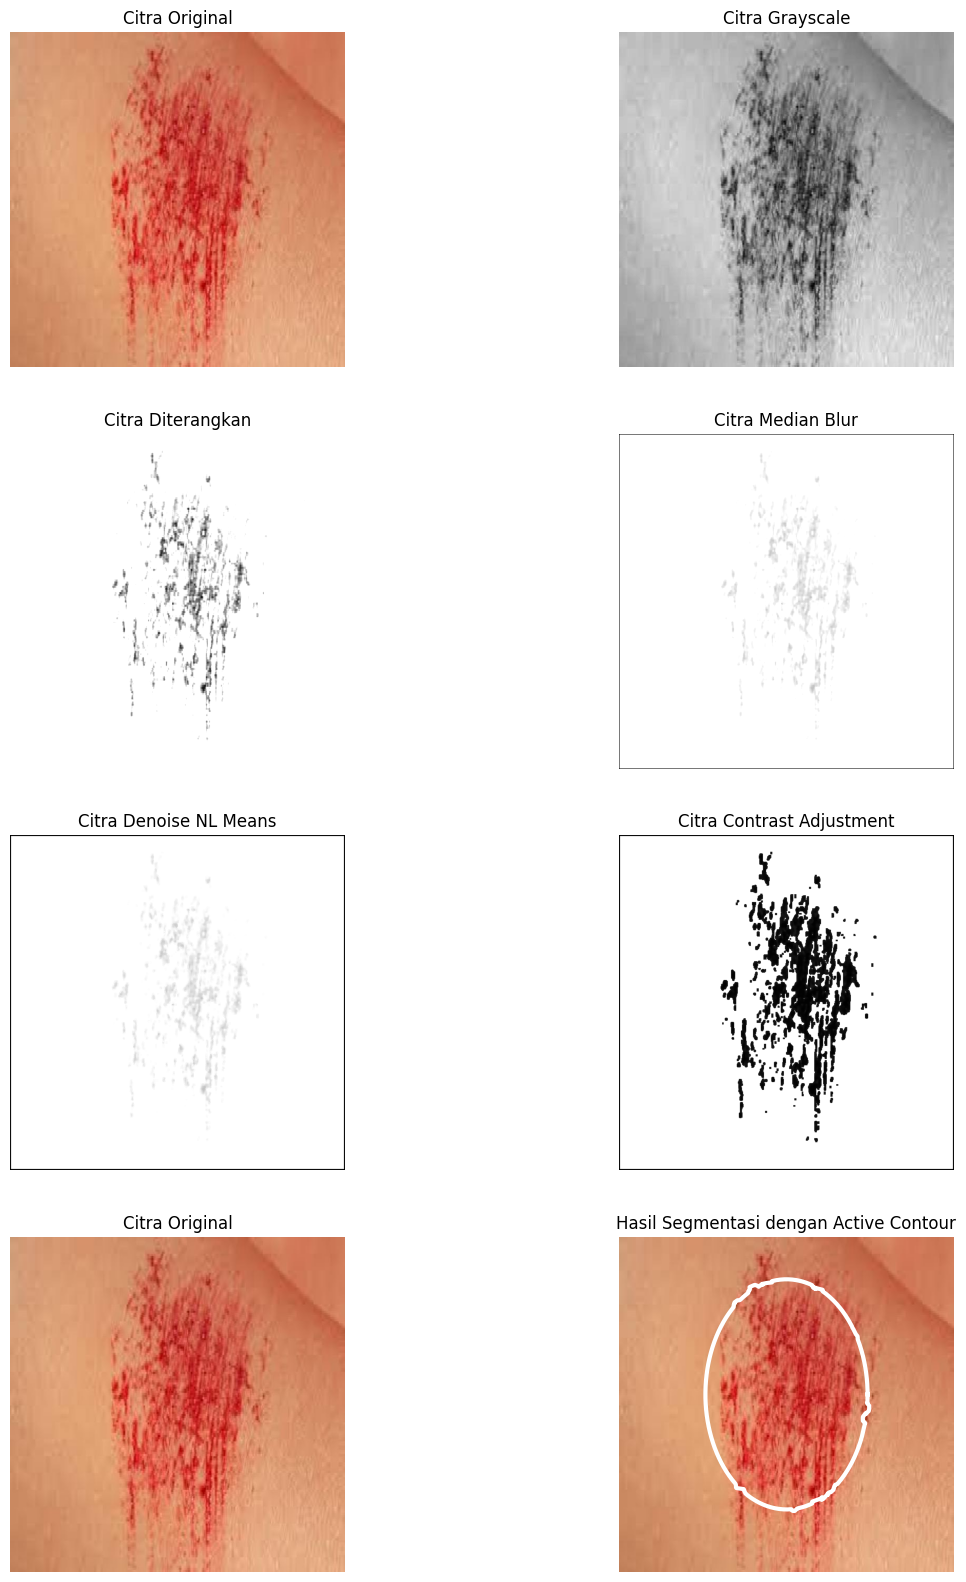

In [5]:
seg_active_contour(folder='abrasions', nomor=3, bright=145, x=300, a=220, y=320, b=155)

#### 2. Citra bruises(2).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=2, bright=75, x=300, a=250, y=320, b=300)

#### 3. Citra burns(36).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=36, bright=215, x=300, a=250, y=320, b=300)

#### 4. Citra cut(15).jpg

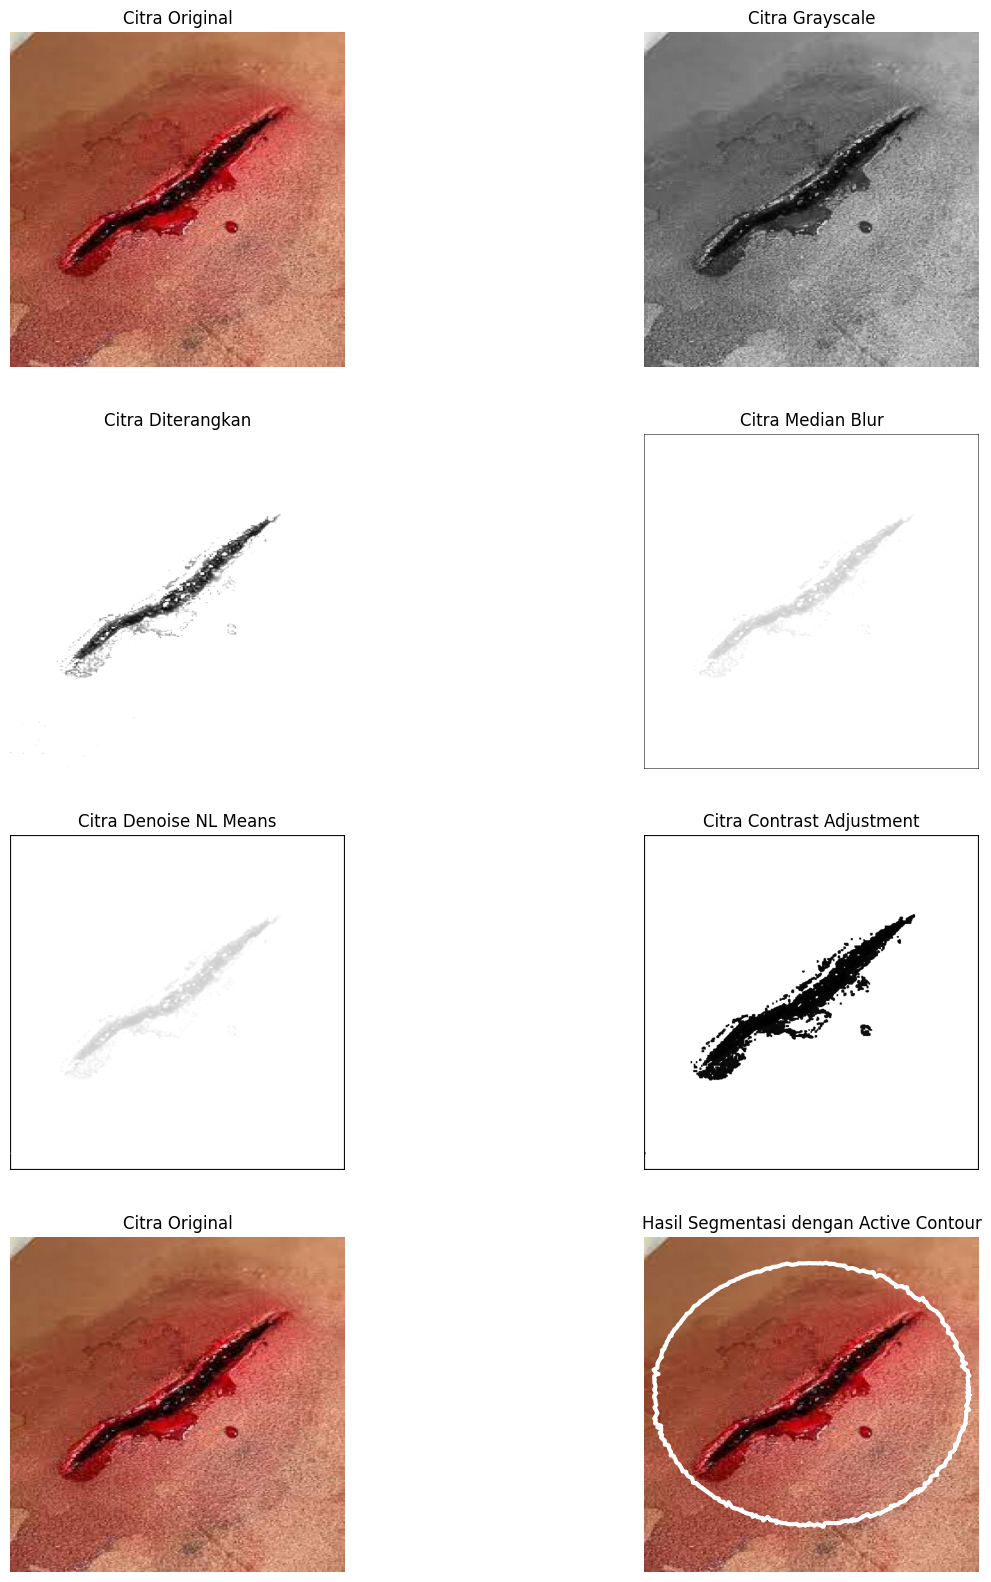

In [22]:
seg_active_contour(folder='cut', nomor=15, bright=200, x=300, a=250, y=320, b=300)

#### 5. Citra laceration(15).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=15, bright=120, x=300, a=300, y=320, b=300)

#### 6. Citra ingrown_nail(4).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=4, bright=146, x=320, a=150, y=360, b=150)

#### 7. Citra stab_wound(5).jpg

In [ ]:
seg_active_contour(folder='stab_wound', nomor=5, bright=180, x=250, a=200, y=250, b=200)

#### 8. Citra abrasions(1).jpg

In [ ]:
seg_active_contour(folder='abrasions', nomor=1, bright=140, x=300, a=200, y=320, b=130)

#### 9. Citra bruises(1).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=1, bright=80, x=300, a=200, y=430, b=130)

#### 10. Citra burns(24).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=24, bright=160, x=350, a=220, y=300, b=250)

#### 11. Citra abrasions(19).jpg

In [ ]:
seg_active_contour(folder='abrasions', nomor=19, bright=150, x=400, a=200, y=320, b=130)

#### 12. Citra bruises(9).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=9, bright=100, x=350, a=450, y=320, b=450)

#### 13. Citra burns(22).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=22, bright=120, x=280, a=100, y=350, b=100)

#### 14. Citra cut(1).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=1, bright=180, x=300, a=300, y=320, b=300)

#### 15. Citra laceration(2).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=2, bright=215, x=300, a=150, y=320, b=150)

#### 16. Citra ingrown_nail(26).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=26, bright=160, x=340, a=150, y=300, b=150)

#### 17. Citra stab_wound(8).jpg

In [ ]:
seg_active_contour(folder='stab_wound', nomor=8, bright=180, x=300, a=200, y=300, b=200)

#### 18. Citra cut(2).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=2, bright=200, x=300, a=250, y=320, b=250)

#### 19. Citra laceration(10).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=10, bright=140, x=300, a=200, y=400, b=100)

#### 20. Citra ingrown_nail(28).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=28, bright=157, x=150, a=120, y=430, b=100)

#### 21. Citra abrasions(17).jpg

In [ ]:
seg_active_contour(folder='abrasions', nomor=17, bright=155, x=300, a=250, y=320, b=240)

#### 22. Citra bruises(18).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=18, bright=90, x=300, a=200, y=350, b=200)

#### 23. Citra burns(22).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=22, bright=125, x=300, a=150, y=380, b=150)

#### 24. Citra cut(20).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=20, bright=126, x=300, a=220, y=290, b=220)

#### 25. Citra laceration(14).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=14, bright=180, x=300, a=200, y=300, b=200)

#### 26. Citra ingrown_nail(16).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=16, bright=144, x=360, a=120, y=140, b=120)

#### 27. Citra stab_wound(20).jpg

In [ ]:
seg_active_contour(folder='stab_wound', nomor=20, bright=215, x=300, a=200, y=250, b=200)

#### 28. Citra stab_wound(23).jpg

In [ ]:
seg_active_contour(folder='stab_wound', nomor=23, bright=190, x=300, a=200, y=350, b=200)